In [19]:
import torch
import requests
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline, DDIMScheduler


# Useful function for later
def load_image(url, size=None):
    response = requests.get(url, timeout=0.2)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    if size is not None:
        img = img.resize(size)
    return img

device = "cuda"

100%|██████████| 50/50 [00:05<00:00,  9.44it/s]


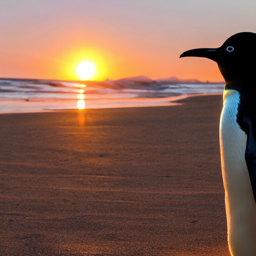

In [9]:
pipe = StableDiffusionPipeline.from_pretrained("/home/jiuxia/tmp/stable-diffusion-v1-5").to(device)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
# Sample an image to make sure it is all working
prompt = "Beautiful DSLR Photograph of a penguin on the beach, golden hour"
negative_prompt = "blurry, ugly, stock photo"
im = pipe(prompt, negative_prompt=negative_prompt).images[0]
im.resize((256, 256))  # Resize for convenient viewing

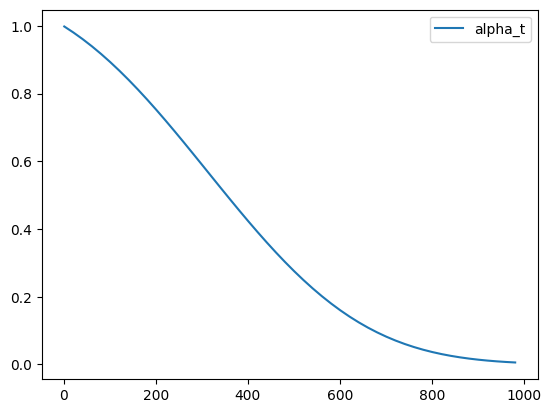

In [6]:
# Plot 'alpha' (alpha_bar in DDPM language, alphas_cumprod in Diffusers for clarity)
timesteps = pipe.scheduler.timesteps.cpu()
alphas = pipe.scheduler.alphas_cumprod[timesteps]
plt.plot(timesteps, alphas, label="alpha_t")
plt.legend()

In [ ]:
#去掉ddim中的sigma，自己按照公式写sample代码

100%|██████████| 50/50 [00:05<00:00,  9.47it/s]
/home/jiuxia/libs/python/anaconda3/envs/comfyui/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


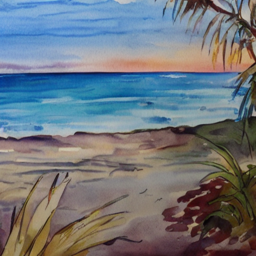

In [10]:
# Sample function (regular DDIM)
@torch.no_grad()
def sample(
    prompt,
    start_step=0,
    start_latents=None,
    guidance_scale=3.5,
    num_inference_steps=30,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt="",
    device=device,
):

    # Encode prompt
    text_embeddings = pipe._encode_prompt(
        prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 64, 64, device=device)
        start_latents *= pipe.scheduler.init_noise_sigma

    latents = start_latents.clone()

    for i in tqdm(range(start_step, num_inference_steps)):

        t = pipe.scheduler.timesteps[i]

        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Normally we'd rely on the scheduler to handle the update step:
        # latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

        # Instead, let's do it ourselves: sigma设为0
        prev_t = max(1, t.item() - (1000//num_inference_steps))
        alpha_t = pipe.scheduler.alphas_cumprod[t]
        alpha_t_prev = pipe.scheduler.alphas_cumprod[prev_t]
        x0 = (latents - (1- alpha_t).sqrt() * noise_pred) / alpha_t.sqrt()
        direction_point_xt = (1 - alpha_t_prev).sqrt() * noise_pred
        latents = alpha_t_prev.sqrt() * x0 + direction_point_xt

    # Post-processing
    images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)

    return images

# Test our sampling function by generating an image
sample("Watercolor painting of a beach sunset", negative_prompt=negative_prompt, num_inference_steps=50)[0].resize(
    (256, 256)
)

In [ ]:
#通过 ddim反向，实现对原有图片的可控编辑。相比直接img2img，可以更多的保留原始图片内容
#核心：1.timestep反过来，2、t和t-1反过来

In [20]:
# https://www.pexels.com/photo/a-beagle-on-green-grass-field-8306128/
input_image = load_image("https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg", size=(256, 256))
#input_image

ReadTimeout: HTTPSConnectionPool(host='images.pexels.com', port=443): Read timed out. (read timeout=0.2)

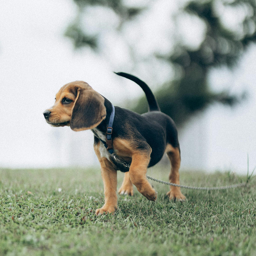

In [21]:
input_image

In [22]:
input_image_prompt = "Photograph of a puppy on the grass"
# Encode with VAE
with torch.no_grad():
    latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device) * 2 - 1)
l = 0.18215 * latent.latent_dist.sample()

In [23]:
## Inversion
@torch.no_grad()
def invert(
    start_latents,
    prompt,
    guidance_scale=3.5,
    num_inference_steps=80,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt="",
    device=device,
):

    # Encode prompt
    text_embeddings = pipe._encode_prompt(
        prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # Latents are now the specified start latents
    latents = start_latents.clone()

    # We'll keep a list of the inverted latents as the process goes on
    intermediate_latents = []

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Reversed timesteps <<<<<<<<<<<<<<<<<<<<
    timesteps = reversed(pipe.scheduler.timesteps)

    for i in tqdm(range(1, num_inference_steps), total=num_inference_steps - 1):

        # We'll skip the final iteration
        if i >= num_inference_steps - 1:
            continue

        t = timesteps[i]

        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        current_t = max(0, t.item() - (1000 // num_inference_steps))  # t
        next_t = t  # min(999, t.item() + (1000//num_inference_steps)) # t+1
        alpha_t = pipe.scheduler.alphas_cumprod[current_t]
        alpha_t_next = pipe.scheduler.alphas_cumprod[next_t]

        # Inverted update step (re-arranging the update step to get x(t) (new latents) as a function of x(t-1) (current latents)
        latents = (latents - (1 - alpha_t).sqrt() * noise_pred) * (alpha_t_next.sqrt() / alpha_t.sqrt()) + (
            1 - alpha_t_next
        ).sqrt() * noise_pred

        # Store
        intermediate_latents.append(latents)

    return torch.cat(intermediate_latents)

In [24]:
inverted_latents = invert(l, input_image_prompt, num_inference_steps=50)
inverted_latents.shape

/home/jiuxia/libs/python/anaconda3/envs/comfyui/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:308: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 49/49 [00:01<00:00, 30.84it/s]


torch.Size([48, 4, 32, 32])

/home/jiuxia/libs/python/anaconda3/envs/comfyui/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


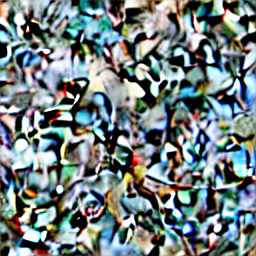

In [25]:
# Decode the final inverted latents
with torch.no_grad():
    im = pipe.decode_latents(inverted_latents[-1].unsqueeze(0))
pipe.numpy_to_pil(im)[0]

100%|██████████| 50/50 [00:01<00:00, 29.67it/s]


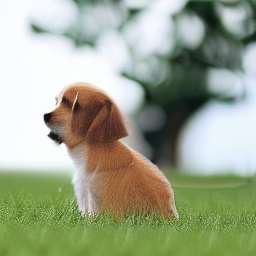

In [26]:
pipe(input_image_prompt, latents=inverted_latents[-1][None], num_inference_steps=50, guidance_scale=3.5).images[0]

100%|██████████| 20/20 [00:00<00:00, 30.86it/s]


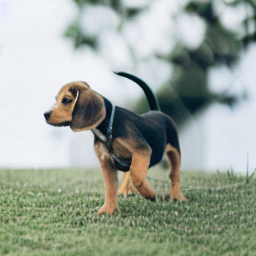

In [28]:
# The reason we want to be able to specify start step
start_step = 30
sample(
    input_image_prompt,
    start_latents=inverted_latents[-(start_step + 1)][None],
    start_step=start_step,
    num_inference_steps=50,
)[0]

100%|██████████| 63/63 [00:01<00:00, 32.01it/s]


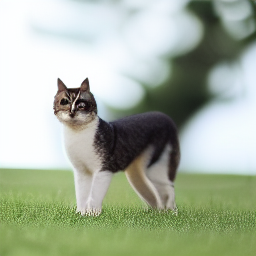

In [44]:
# Sampling with a new prompt
start_step = 12
new_prompt = input_image_prompt.replace("puppy", "cat")
sample(
    new_prompt,
    start_latents=inverted_latents[-(start_step + 1)][None],
    start_step=start_step,
    num_inference_steps=75,
)[0]

100%|██████████| 40/40 [00:01<00:00, 30.53it/s]


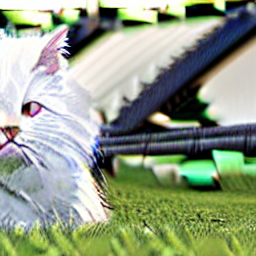

In [45]:
start_step = 10
num_inference_steps = 50
pipe.scheduler.set_timesteps(num_inference_steps)
noisy_l = pipe.scheduler.add_noise(l, torch.randn_like(l), pipe.scheduler.timesteps[start_step])
sample(new_prompt, start_latents=noisy_l, start_step=start_step, num_inference_steps=num_inference_steps)[0]

In [46]:
def edit(input_image, input_image_prompt, edit_prompt, num_steps=100, start_step=30, guidance_scale=3.5):
    with torch.no_grad():
        latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device) * 2 - 1)
    l = 0.18215 * latent.latent_dist.sample()
    inverted_latents = invert(l, input_image_prompt, num_inference_steps=num_steps)
    final_im = sample(
        edit_prompt,
        start_latents=inverted_latents[-(start_step + 1)][None],
        start_step=start_step,
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale,
    )[0]
    return final_im

100%|██████████| 38/38 [00:01<00:00, 30.27it/s]


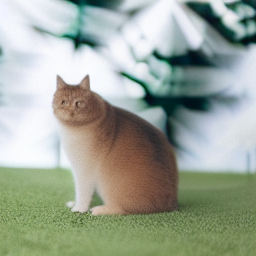

In [60]:
#
edit(input_image, "A dog on the grass", "an cat on the grass", num_steps=50, start_step=12)

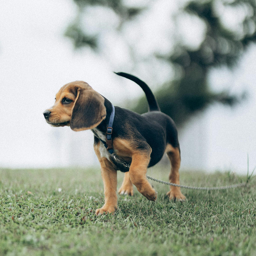

In [58]:
input_image